## Importing Libraries and Modules

In [1]:
import cv2
import numpy as np
import os
import math
import pandas as pd
import matplotlib.pyplot as plt

## Visualisation of the Processed Images

In [2]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.20)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

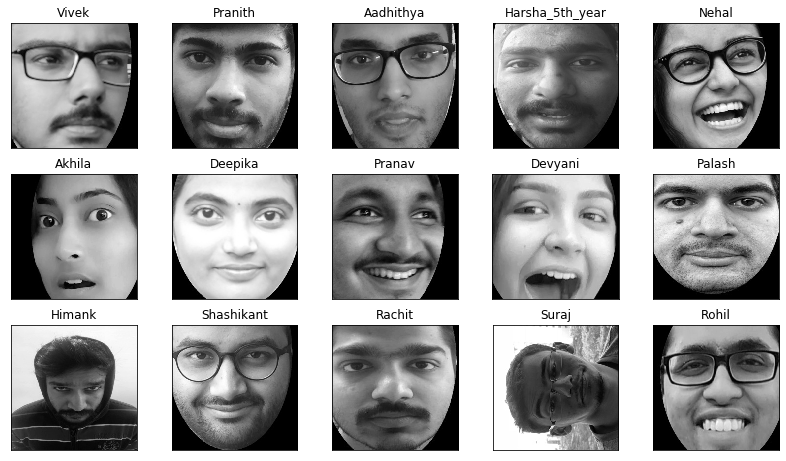

In [3]:
dir = '../processed-images'
folders = os.listdir(dir)[1:16]
photos = [dir + '/' + folder for folder in folders]

all_images = []
for i in range(len(photos)):
    all_images.append(os.listdir(photos[i])[0])

images = []
for i in range(len(photos)):
    images.append(photos[i] + "/" + all_images[i])
    
images = np.array([cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in images])
names = [name for name in folders]
plot_portraits(images, names, 256, 256, n_row=3, n_col=5)

## Reading and Preparing Data

In [4]:
def prepare_data_using_index(path):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    i=1
    j=1
    for folder in os.listdir(path):
        for file in os.listdir(path+folder):
            image = cv2.imread(os.path.join(path+folder, file))
            face, rect = detect_face(image)
            if(j<6): #Equivalent of train_test_split of 0.2
                if(face is not None):
                    X_train.append(face)
                    y_train.append(i)
                j+=1
            elif(j==6):
                if(face is not None):
                    X_test.append(face)
                    y_test.append(i)
                j=1
        i+=1
    return X_train, y_train, X_test, y_test

## Detecting Faces

In [5]:
def detect_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);
    if (len(faces) == 0):
        return None, None
    (x, y, w, h) = faces[0]
    return cv2.resize(gray[y:y+w, x:x+h], (256, 256)) , faces[0]

## Using existing implementations of PCA, LDA and LBP face recognizors

In [6]:
def face_recognizer_type(inp):
    if inp == 'PCA':
        face_recognizer = cv2.face.EigenFaceRecognizer_create()
    elif inp == 'LDA':
        face_recognizer = cv2.face.FisherFaceRecognizer_create()
    elif inp == 'LBP':
        face_recognizer = cv2.face.LBPHFaceRecognizer_create()
    return face_recognizer

In [7]:
def predict(X, y):
    X_labels = [face_recognizer.predict(face)[0] for face in X]
    return sum(1 for x, y in zip(X_labels, y) if x==y)/len(y), X_labels

## Testing

In [8]:
path = '../processed-images/'
X_train, y_train, X_test, y_test = prepare_data_using_index(path)

face_recognizer = face_recognizer_type('LBP')
face_recognizer.train(np.array(X_train), np.array(y_train))

## Top accuracies

In [9]:
def accuracies(n):
    score = 0
    for i, img in enumerate(X_test):
        num = 0
        face_recognizer.predict(img)[0]
        face_recognizer.predict_collect(img, collector)
        results = collector.getResults(sorted=True)

        for label,dist in results:
            if num < n:
                if label == y_test[i]:
                    score += 1
                    break
            else:
                break
            num += 1
    return score

In [10]:
total = len(X_test)
collector = cv2.face.StandardCollector_create()

top_1_score = accuracies(1)
top_3_score = accuracies(3)
top_10_score = accuracies(10)

print("Top 1 accuracy", top_1_score/total)
print("Top 3 accuracy", top_3_score/total)
print("Top 10 accuracy", top_10_score/total)

Top 1 accuracy 0.5454545454545454
Top 3 accuracy 0.6363636363636364
Top 10 accuracy 0.7272727272727273
